In [28]:
#SYSTEM 
import subprocess

def run_gnina(protein,ligand,center_x,center_y,center_z,size_x,size_y,size_z):
    cmd=[
    "./gnina",   
    #      "--config",box_file,
                "--center_x",str(center_x),
    "--center_y",str(center_y),
    "--center_z",str(center_z),
    "--size_x",str(size_x),
    "--size_y",str(size_y),
    "--size_z",str(size_z),
    # "--cnn_center_x",center_x,
    # "--cnn_center_y",center_y,
    # "--cnn_center_z",center_z,
    # "--minimize", 
    #      "--log","test.log",
    "--num_mc_saved", str(1),
    "--num_modes", str(1),  
    "--seed", str(42),
    "--autobox_extend", str(1),
    "--exhaustiveness", str(8),
            "--cnn_scoring","rescore",
            "--verbosity=0",
    "-r", str(protein),
    "-l", f'ligands/{ligand}.pdb',
    "--out" , f"results/{ligand}.pdb"
        ] 
    result=subprocess.run(cmd,stdout=subprocess.PIPE  )
  #  return result.stdout.decode('utf-8')

def read_box_file(box_file):
    with open(box_file) as f:
        lines=f.readlines()
    center_x = lines[0].split('=')[1].strip()
    center_y = lines[1].split('=')[1].strip()
    center_z = lines[2].split('=')[1].strip()
    size_x = lines[3].split('=')[1].strip()
    size_y = lines[4].split('=')[1].strip()
    size_z = lines[5].split('=')[1].strip()
    # convert to float
    center_x = float(center_x)
    center_y = float(center_y)
    center_z = float(center_z)
    size_x = float(size_x)
    size_y = float(size_y)
    size_z = float(size_z)
    

    return center_x,center_y,center_z,size_x,size_y,size_z


In [29]:
#INIT
init_smiles='O=C(C1=CC=CC=C1)NCCN1CCN(CC1)C1=CC=CC=C1'

from rdkit import Chem
from rdkit.Chem import AllChem

m = Chem.MolFromSmiles(init_smiles)
m = Chem.AddHs(m)
AllChem.EmbedMolecule(m)
AllChem.MMFFOptimizeMolecule(m)
Chem.MolToPDBFile(m,'ligands/ligand.pdb')

In [30]:
center_x,center_y,center_z,size_x,size_y,size_z=read_box_file('P22680_3V8D_A_box_2.txt')
run_gnina('P22680_3V8D_A.pdb','ligand',center_x,center_y,center_z,size_x,size_y,size_z)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



In [31]:
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport
import pandas as pd

In [193]:
# INIT DockingStatistics
from plip.basic import config
from plip.structure.preparation import PDBComplex
from Bio.PDB import PDBParser

def atoms_in_bounding_box(pdb_file, center, size):
    """
    List all atom indices in a given bounding box defined by its center and size.
    
    :param pdb_file: Path to the PDB file
    :param center: A tuple of coordinates for the bounding box center (center_x, center_y, center_z)
    :param size: A tuple of sizes along each axis for the bounding box (size_x, size_y, size_z)
    :return: List of atom indices within the bounding box
    """
    center_x, center_y, center_z = center
    size_x, size_y, size_z = size
    
    # Calculate bounding box coordinates
    xmin = center_x - size_x / 2
    xmax = center_x + size_x / 2
    ymin = center_y - size_y / 2
    ymax = center_y + size_y / 2
    zmin = center_z - size_z / 2
    zmax = center_z + size_z / 2
    
    # Load the PDB file
    parser = PDBParser()
    structure = parser.get_structure('protein', pdb_file)
    
    # Iterate through all atoms and check if they lie within the bounding box
    atom_indices = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    # check if it's a carbon atom
                    if atom.element != 'C':
                        continue
                    x, y, z = atom.coord
                    if xmin <= x <= xmax and ymin <= y <= ymax and zmin <= z <= zmax:
                        atom_indices.append(atom.serial_number)
    
    return atom_indices

# Example usage
pdb_file = 'P22680_3V8D_A.pdb'
center = (center_x, center_y, center_z)
size = (size_x, size_y, size_z)
atom_indices = atoms_in_bounding_box(pdb_file, center, size)


In [ ]:
#COMPUTE STATISTICS

In [6]:
def merge_pdb_files_with_hetatm(ligand_file, protein_file, output_file):
    # Read the ligand PDB file
    with open(ligand_file, 'r') as file:
        ligand_content = file.readlines()

    # Read the protein PDB file
    with open(protein_file, 'r') as file:
        protein_content = file.readlines()

    # Separate the ATOM and HETATM lines for protein and ligand
    protein_atoms = [line for line in protein_content if line.startswith('ATOM')]
    protein_hetatms = [line for line in protein_content if line.startswith('HETATM')]
    ligand_hetatms = [line for line in ligand_content if line.startswith('HETATM')]

    # Add MODEL and ENDMDL lines to the protein content if they don't exist
    if not protein_content[0].startswith('MODEL'):
        protein_content.insert(0, 'MODEL        1\n')
        protein_content.append('ENDMDL\n')

    # Combine the protein ATOM, protein HETATM, and ligand HETATM contents
    combined_content = protein_atoms + protein_hetatms + ligand_hetatms

    # Ensure the combined content ends with END line
    if not combined_content[-1].strip() == 'END':
        combined_content.append('END\n')

    # Write the combined content to the output PDB file
    with open(output_file, 'w') as file:
        file.writelines(combined_content)


# Define the file paths
ligand_pdb = 'results/ligand.pdb'
protein_pdb = 'P22680_3V8D_A.pdb'
complex_pdb = 'complex.pdb'

# Merge the PDB files with HETATM separation
merge_pdb_files_with_hetatm(ligand_pdb, protein_pdb, complex_pdb)

print(f"Merged {ligand_pdb} and {protein_pdb} into {complex_pdb}")



Merged results/ligand.pdb and P22680_3V8D_A.pdb into complex.pdb


In [54]:
def retrieve_plip_interactions(pdb_file):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(pdb_file)  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions

    key, site = sorted(protlig.interaction_sets.items())[0]

    binding_site = BindingSiteReport(site) 

    return getattr(binding_site, "hydrophobic_info")

In [68]:
# 'RESNR',
# 'RESTYPE',
# 'RESCHAIN',
# 'RESNR_LIG',
# 'RESTYPE_LIG',
# 'RESCHAIN_LIG',
# 'DIST',
# 'LIGCARBONIDX',
# 'PROTCARBONIDX',
# 'LIGCOO',
# 'PROTCOO'
interactions_by_site=retrieve_plip_interactions('complex.pdb')
# retrieve PROTCARBONIDX
protcarbonidxs=[ i[8] for i in interactions_by_site]
dists=[ i[6] for i in interactions_by_site]

In [75]:
# internsection with atom_indices
statistics=[
    1/float(dists[protcarbonidxs.index(a)]) if a in protcarbonidxs else 0
    for a in atom_indices
]

[C+1]=[P+1]=[B-1]=O


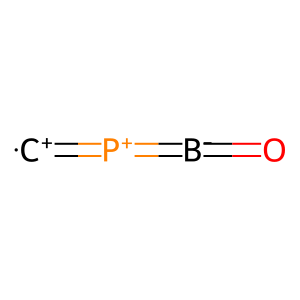

In [176]:
import selfies as sf
import random

alphabet=sf.get_semantic_robust_alphabet() # Gets the alphabet of robust symbols
rnd_selfies=''.join(random.choices(list(alphabet), k=100))
rnd_smiles=sf.decoder(rnd_selfies)
print(rnd_smiles)
# plot smiles
from rdkit import Chem
from rdkit.Chem import Draw
m = Chem.MolFromSmiles(rnd_smiles)
Draw.MolToImage(m)

In [140]:
sf.encoder("C1=CC=CC=C1")

'[C][=C][C][=C][C][=C][Ring1][=Branch1]'

In [15]:
chemical_space = [
    # ('[#B-1]', 0.0001),  # Very rare
    # ('[#B]', 0.0005),    # Rare
    # ('[#Branch1]', 0.05),
    # ('[#Branch2]', 0.03),
    # ('[#Branch3]', 0.01),
    # ('[#C+1]', 0.0001),  # Very rare
    # ('[#C-1]', 0.0001),  # Very rare
    # ('[#C]', 0.005),     # Triple bond, rare in organic chemistry
    # ('[#N+1]', 0.0005),  # Rare
    # ('[#N]', 0.01),      # Triple-bonded nitrogen, not very common
    # ('[#O+1]', 0.0001),  # Very rare
    # ('[#P+1]', 0.00005), # Extremely rare
    # ('[#P-1]', 0.00005), # Extremely rare
    # ('[#P]', 0.0001),    # Very rare
    # ('[#S+1]', 0.0001),  # Very rare
    # ('[#S-1]', 0.0001),  # Very rare
    # ('[#S]', 0.0005),    # Rare
    ('[=B+1]', 0.00001), # Extremely rare
    ('[=B-1]', 0.00001), # Extremely rare
    ('[=B]', 0.0001),    # Very rare
    ('[=Branch1]', 0.04),
    ('[=Branch2]', 0.02),
    ('[=Branch3]', 0.005),
    ('[=C+1]', 0.0001),  # Very rare
    ('[=C-1]', 0.0001),  # Very rare
    ('[=C]', 0.15),      # Double-bonded carbon, common
    ('[=N+1]', 0.0005),  # Rare
    ('[=N-1]', 0.0005),  # Rare
    ('[=N]', 0.03),      # Double-bonded nitrogen, fairly common
    ('[=O+1]', 0.0001),  # Very rare
    ('[=O]', 0.1),       # Carbonyl group, very common
    ('[=P+1]', 0.00001), # Extremely rare
    ('[=P-1]', 0.00001), # Extremely rare
    ('[=P]', 0.0005),    # Rare
    ('[=Ring1]', 0.08),
    ('[=Ring2]', 0.05),
    ('[=Ring3]', 0.02),
    ('[=S+1]', 0.0001),  # Very rare
    ('[=S-1]', 0.0001),  # Very rare
    ('[=S]', 0.01),      # Not very common
    ('[B+1]', 0.00005),  # Extremely rare
    ('[B-1]', 0.00005),  # Extremely rare
    ('[B]', 0.0005),     # Rare
    ('[Br]', 0.01),      # Not very common
    ('[Branch1]', 0.1),
    ('[Branch2]', 0.05),
    ('[Branch3]', 0.02),
    ('[C+1]', 0.0005),   # Rare
    ('[C-1]', 0.0005),   # Rare
    ('[C]', 0.25),       # Single-bonded carbon, very common
    ('[Cl]', 0.02),      # Fairly common
    ('[F]', 0.015),      # Fairly common
    ('[H]', 0.3),        # Most common, present in almost all organic molecules
    ('[I]', 0.005),      # Less common than other halogens
    ('[N+1]', 0.005),    # Not very common
    ('[N-1]', 0.005),    # Not very common
    ('[N]', 0.08),       # Common in organic molecules
    ('[O+1]', 0.0001),   # Very rare
    ('[O-1]', 0.005),    # Not very common
    ('[O]', 0.15),       # Very common in organic molecules
    ('[P+1]', 0.00001),  # Extremely rare
    ('[P-1]', 0.00001),  # Extremely rare
    ('[P]', 0.005),      # Not very common
    ('[Ring1]', 0.1),
    ('[Ring2]', 0.06),
    ('[Ring3]', 0.03),
    ('[S+1]', 0.0005),   # Rare
    ('[S-1]', 0.0005),   # Rare
    ('[S]', 0.02)        # Fairly common in organic molecules
]

In [16]:
# sum of probabilities
total_prob=sum([p for _,p in chemical_space])

In [17]:
# normalize
chemical_space=[
    (s,p/total_prob) for s,p in chemical_space
]

In [18]:
chemical_space

[('[=B+1]', 5.747588886462131e-06),
 ('[=B-1]', 5.747588886462131e-06),
 ('[=B]', 5.747588886462131e-05),
 ('[=Branch1]', 0.022990355545848523),
 ('[=Branch2]', 0.011495177772924262),
 ('[=Branch3]', 0.0028737944432310654),
 ('[=C+1]', 5.747588886462131e-05),
 ('[=C-1]', 5.747588886462131e-05),
 ('[=C]', 0.08621383329693195),
 ('[=N+1]', 0.00028737944432310656),
 ('[=N-1]', 0.00028737944432310656),
 ('[=N]', 0.017242766659386392),
 ('[=O+1]', 5.747588886462131e-05),
 ('[=O]', 0.05747588886462131),
 ('[=P+1]', 5.747588886462131e-06),
 ('[=P-1]', 5.747588886462131e-06),
 ('[=P]', 0.00028737944432310656),
 ('[=Ring1]', 0.045980711091697046),
 ('[=Ring2]', 0.028737944432310654),
 ('[=Ring3]', 0.011495177772924262),
 ('[=S+1]', 5.747588886462131e-05),
 ('[=S-1]', 5.747588886462131e-05),
 ('[=S]', 0.005747588886462131),
 ('[B+1]', 2.8737944432310656e-05),
 ('[B-1]', 2.8737944432310656e-05),
 ('[B]', 0.00028737944432310656),
 ('[Br]', 0.005747588886462131),
 ('[Branch1]', 0.05747588886462131)

In [185]:
chemical_space = [
    ('[#B-1]', 0.0037064492216456668),
    ('[#B]', 0.0074128984432913336),
    ('[#Branch1]', 0.018532246108228335),
    ('[#Branch2]', 0.011119347664937),
    ('[#Branch3]', 0.0074128984432913336),
    ('[#C+1]', 0.0037064492216456668),
    ('[#C-1]', 0.011119347664937),
    ('[#C]', 0.11119347664936999),
    ('[#N+1]', 0.0037064492216456668),
    ('[#N]', 0.018532246108228335),
    ('[#O+1]', 0.0037064492216456668),
    ('[#P+1]', 0.0018532246108228334),
    ('[#P-1]', 0.0018532246108228334),
    ('[#P]', 0.0074128984432913336),
    ('[#S+1]', 0.0037064492216456668),
    ('[#S-1]', 0.0037064492216456668),
    ('[#S]', 0.014825796886582667),
    ('[=B+1]', 0.0018532246108228334),
    ('[=B-1]', 0.0018532246108228334),
    ('[=B]', 0.0037064492216456668),
    ('[=Branch1]', 0.011119347664937),
    ('[=Branch2]', 0.0074128984432913336),
    ('[=Branch3]', 0.0037064492216456668),
    ('[=C+1]', 0.0018532246108228334),
    ('[=C-1]', 0.0037064492216456668),
    ('[=C]', 0.09266123054114167),
    ('[=N+1]', 0.0018532246108228334),
    ('[=N-1]', 0.0018532246108228334),
    ('[=N]', 0.011119347664937),
    ('[=O+1]', 0.0018532246108228334),
    ('[=O]', 0.0074128984432913336),
    ('[=P+1]', 0.0007412898443291333),
    ('[=P-1]', 0.0007412898443291333),
    ('[=P]', 0.0037064492216456668),
    ('[=Ring1]', 0.014825796886582667),
    ('[=Ring2]', 0.011119347664937),
    ('[=Ring3]', 0.0074128984432913336),
    ('[=S+1]', 0.0018532246108228334),
    ('[=S-1]', 0.0018532246108228334),
    ('[=S]', 0.011119347664937),
    ('[B+1]', 0.0018532246108228334),
    ('[B-1]', 0.0037064492216456668),
    ('[B]', 0.0074128984432913336),
    ('[Br]', 0.0074128984432913336),
    ('[Branch1]', 0.014825796886582667),
    ('[Branch2]', 0.011119347664937),
    ('[Branch3]', 0.0074128984432913336),
    ('[C+1]', 0.0037064492216456668),
    ('[C-1]', 0.011119347664937),
    ('[C]', 0.14825796886582668),
    ('[Cl]', 0.011119347664937),
    ('[F]', 0.0074128984432913336),
    ('[H]', 0.18532246108228334),
    ('[I]', 0.0037064492216456668),
    ('[N+1]', 0.0037064492216456668),
    ('[N-1]', 0.0037064492216456668),
    ('[N]', 0.02594514455151967),
    ('[O+1]', 0.0018532246108228334),
    ('[O-1]', 0.0037064492216456668),
    ('[O]', 0.03706449221645667),
    ('[P+1]', 0.0007412898443291333),
    ('[P-1]', 0.0007412898443291333),
    ('[P]', 0.0037064492216456668),
    ('[Ring1]', 0.018532246108228335),
    ('[Ring2]', 0.011119347664937),
    ('[Ring3]', 0.0074128984432913336),
    ('[S+1]', 0.0018532246108228334),
    ('[S-1]', 0.0018532246108228334),
    ('[S]', 0.014825796886582667)
]

In [189]:
np.random.choice( 
            [x[0] for x in chemical_space], p=[x[1] for x in chemical_space]
        )

'[=C]'

In [190]:
from plip.structure.preparation import PDBComplex

my_mol = PDBComplex()




In [192]:
dir(my_mol)

['Mapper',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_output_path',
 'altconf',
 'analyze',
 'atoms',
 'characterize_complex',
 'corrected_pdb',
 'covalent',
 'excluded',
 'extract_bs',
 'filetype',
 'get_atom',
 'information',
 'interaction_sets',
 'ligands',
 'load_pdb',
 'modres',
 'output_path',
 'protcomplex',
 'pymol_name',
 'res_belongs_to_bs',
 'resis',
 'sourcefiles']

In [1]:
import prody as pd
import portein
import matplotlib.pyplot as plt
import numpy as np
import yaml
import warnings
warnings.filterwarnings('ignore')
portein.compile_numba_functions()

In [2]:
!pip install git+https://github.com/TurtleTools/portein

  Cloning https://github.com/TurtleTools/portein to /tmp/pip-req-build-bkq1071j
  Running command git clone --filter=blob:none --quiet https://github.com/TurtleTools/portein /tmp/pip-req-build-bkq1071j
  Resolved https://github.com/TurtleTools/portein to commit 1ed9f1ad4375d825f38661bf61d3da366d3b50de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for portein: filename=portein-0.0.1-py2.py3-none-any.whl size=19248 sha256=41130e5bc9726105831deddf5b63e765b7ab3fd0adc8527008fff6cd42a80629
  Stored in directory: /tmp/pip-ephem-wheel-cache-oxjcwgmj/wheels/47/1f/bf/e20f4cc0678a7f5444aa9b8876a0155fbf579263a574d082be
Successfully built portein


In [4]:
protein_config = portein.ProteinConfig(pdb_file="7lc2", rotate=True, output_prefix="examples/7lc2",
                                       chain_colormap="Set3", 
                                       highlight_residues={"A": {"black": [30, 35], "red": list(range(10,20))},
                                                           "B": {"black": [25], "red": list(range(10, 16))}},
                                       width=1000)


@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 7lc2 downloaded (7lc2.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 3833 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 3833 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 3833 atoms and 1 coordinate set(s) were parsed in 0.06s.


In [2]:
illustrate_config=portein.IllustrateConfig(
    illustra            te_binary="/home/flowers-user/adtool/examples/docking/systems/illustrate",
)

In [5]:

illustrate = portein.Illustrate(protein_config=protein_config, illustrate_config=illustrate_config)
image_file = illustrate.run()

In [15]:
pwd

'/home/flowers-user/adtool/examples/docking/systems'

In [7]:
response

<Response [202]>

In [1]:
import sys
import numpy as np
from PyQt5.QtWidgets import QApplication
import pyqtgraph as pg
import pyqtgraph.opengl as gl
from Bio import PDB

# Define atom colors
atom_colors = {
    'C': (0.5, 0.5, 0.5, 1),  # Gray
    'N': (0, 0, 1, 1),        # Blue
    'O': (1, 0, 0, 1),        # Red
    'S': (1, 1, 0, 1),        # Yellow
    'P': (1, 0.5, 0, 1),      # Orange
    'H': (0.9, 0.9, 0.9, 1),  # Light gray
}

def parse_pdb(pdb_file):
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    
    atoms = []
    bonds = []
    
    for model in structure:
        for chain in model:
            prev_atom = None
            for residue in chain:
                i=0
                for atom in residue:
                    atoms.append((atom.get_coord(), atom.element))
                    if prev_atom is not None:
                        bonds.append((prev_atom, len(atoms) - 1))
                    prev_atom = len(atoms) - 1
                    i+=1
                    if i>5:
                        break
    
    return atoms, np.array(bonds)

def plot_protein(atoms, bonds):
    app = QApplication(sys.argv)
    w = gl.GLViewWidget()
    w.show()
    w.setWindowTitle('Protein Structure Viewer')
    w.setCameraPosition(distance=40)

    # Plot atoms
    pos = np.array([atom[0] for atom in atoms])
    colors = np.array([atom_colors.get(atom[1], (0.5, 0.5, 0.5, 1)) for atom in atoms])
    
    sp = gl.GLScatterPlotItem(pos=pos, color=colors, size=0.5)
    w.addItem(sp)

    # Plot bonds
    if len(bonds) > 0:
        bond_pos = pos[bonds]
        bond_colors = np.tile((0.7, 0.7, 0.7, 1), (len(bonds), 1))
        bonds_item = gl.GLLinePlotItem(pos=bond_pos, color=bond_colors, width=2, mode='lines')
        w.addItem(bonds_item)

    # Start Qt event loop
    sys.exit(app.exec_())


# Usage
pdb_file = 'P22680_3V8D_A.pdb'
atoms, bonds = parse_pdb(pdb_file)
plot_protein(atoms, bonds)


libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
QOpenGLWidget: Failed to create context
QOpenGLWidget: Failed to create context
qt.qpa.backingstore: composeAndFlush: QOpenGLContext creation failed
qt.qpa.backingstore: composeAndFlush: makeCurrent() failed
qt.qpa.ba

SystemExit: 0

/home/flowers-user/anaconda3/envs/adtool/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
pip install pyqtgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.2 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install PyQt5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 40.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.0/276.0 kB 51.4 MB/s eta 0:00:00


In [10]:
pip install pyopengl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import base64
import os
import time

def render(protein, ligand):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless') 
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    print("Rendering...")

    # HTML content
    html_content = f'''
    <html>
    <body style="margin: 0; padding: 0; display: block;">
    <div id="3dmolviewer" style="position: relative; width: 512px; height: 512px;">
    <p id="viewer3dmolwarning" style="background-color:#ffcccc;color:black"><br></p>
    </div>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/3Dmol/2.2.0/3Dmol-min.js"></script>
    <script>
    var viewer = null;
    var warn = document.getElementById("viewer3dmolwarning");
    if(warn) {{
        warn.parentNode.removeChild(warn);
    }}
    
    viewer = $3Dmol.createViewer(document.getElementById("3dmolviewer"),{{backgroundColor:"white"}});
    viewer.zoomTo();
    viewer.addModel(`{protein}`,"pdb");
    viewer.addModel(`{ligand}`,"pdb");
    viewer.setStyle({{"model": 0}},{{"cartoon": {{"color": "spectrum", "opacity": 0.7}}}});
    viewer.setStyle({{"model": 1}},{{"stick": {{"colorscheme": "cyanCarbon"}}}});
    viewer.zoomTo({{"model": 1}});
    viewer.zoom(0.5);
    viewer.render();

    const nb_frames = 60;
    var pngURIs = [];
    for (var i = 0; i < nb_frames; i++) {{
        viewer.rotate(360/nb_frames , "y");
        pngURIs.push(viewer.pngURI());
    }}
    document.body.setAttribute('data-png-uris', JSON.stringify(pngURIs));
    document.body.setAttribute('data-render-complete', 'true');
    </script>
    </body>
    </html>
    '''

    with open('temp.html', 'w') as f:
        f.write(html_content)

    driver.get('file://' + os.path.abspath('temp.html'))



    print("Rendering complete.")    


    png_uris = driver.execute_script("return JSON.parse(document.body.getAttribute('data-png-uris'));")

    png_frames = []
    for uri in png_uris:
        png_data = uri.split(',')[1]
        png_bytes = base64.b64decode(png_data)
        png_frames.append(png_bytes)

    driver.quit()

    os.remove('temp.html')

    return png_frames




protein = open('P22680_3V8D_A.pdb').read()
ligand = open('tmp/docked_ligand.pdb').read()


frames = render(protein, ligand)

import imageio

images = [imageio.v2.imread(frame) for frame in frames]

imageio.mimsave('docking.mp4', images, fps=10)


print(f"Saved {len(frames)} frames.")

Rendering...
Rendering complete.
Saved 60 frames.
